# Problem Set 6
Sophie Sun

In [28]:
# import packages
import pandas as pd
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import datetime
import math
import scipy
from scipy.optimize import fsolve
from scipy.optimize import broyden1
from scipy.optimize import minimize
from scipy import optimize as opt
from scipy import stats
import pandas_datareader.data as web
import pickle

Part 1:
    fjac: array([[-1.]])
     fun: 0.0
 message: 'The solution converged.'
    nfev: 6
     qtf: array([9.68114477e-14])
       r: array([-0.0075478])
  status: 1
 success: True
       x: array([1.37995685])
Part 3:
 final_simplex: (array([[2.78203125],
       [2.78195313]]), array([5.75786814, 5.75786857]))
           fun: 5.757868138613711
       message: 'Optimization terminated successfully.'
          nfev: 38
           nit: 19
        status: 0
       success: True
             x: array([2.78203125])
Part 4:
      fun: array([25.3057913])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.14181367, 11.01160798])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 240
      nit: 27
   status: 0
  success: True
        x: array([0.09823234, 0.95408727])


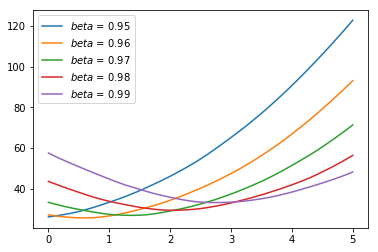

In [24]:
# EXERCISE 1
# function from Scott that cleans the data
def convert_to_daily_with_ffill(df):
    new_idx = pd.date_range('01-01-1950', '07-01-2018')
    df = df.reindex(new_idx)
    df = df.fillna(method="ffill")
    return df
start = datetime.datetime(1950, 1,1)
end = datetime.datetime(2018, 7, 1)
rpce = web.DataReader('PCECC96', 'fred', start, end)
w5000 = web.DataReader('WILL5000INDFC', 'fred', start, end)
w5000 = convert_to_daily_with_ffill(w5000)
gdef = web.DataReader('GDPDEF', 'fred', start, end)
tb = web.DataReader('TB3MS', 'fred', start, end)
df = pd.DataFrame(columns=['rpce', 'w5000', 'tb', 'gdef'], index = rpce.index)
df['rpce'] = rpce
df['w5000'] = w5000
df['gdef'] = gdef
df['inf'] = df['gdef'] / df['gdef'].shift(1)
df['R_nom'] = df['w5000'].shift(-1) / df['w5000']
df['R'] = df['R_nom'] / df['inf']
df['tb'] = tb / 100. + 1    
df['rpce_1'] = rpce.shift(-1)
df  = df.dropna(axis = 0)  
def sdf(γ):
     return (0.99 * (df['rpce_1'] ** (-γ)) / (df['rpce'] ** (-γ)))
def err(γ):
    return (1 - sdf(γ).cov(df['R']) - (sdf(γ).mean()) * (df['R'].mean()))
print("Part 1:\n" + str(opt.root(err, 1.0)))
def err(γ):
    err = np.abs(df['tb'] - 1 / sdf(γ))
    return err.sum()
print("Part 3:\n" + str(opt.minimize(err, 0.8, method = 'Nelder-Mead')))
def sdf(γ, β):
    return (β * (df['rpce_1'] ** (-γ)) / (df['rpce'] ** (-γ)))
def err(params):
    γ, β = params
    err1 = 1 - (sdf(γ, β).cov(df['R'])) - (sdf(γ, β).mean()) * (df['R'].mean())
    err = np.abs(df['tb'] - 1 / sdf(γ, β))
    err2 = err.sum()
    final_err = np.zeros(2)
    final_err[0] = err1
    final_err[1] = err2
    return final_err
def crit(params, *args):
    γ, β = params
    W = args
    error = err(params)
    return error.T @ W @ error
W = np.eye(2)
params_init = np.array([5, 0.5])
result = opt.minimize(crit, params_init, args = W, method = 'L-BFGS-B', bounds = ((0, None), (0, 1)))
print("Part 4:\n" + str(result))
n = 60
N = 5
γ_grid = np.linspace(0, 5, n)
β_grid = np.linspace(0.95, 0.99, N)
vals = np.zeros((n, N))
for i in range(n):
    for j in range(N):
        vals[i, j] = crit((γ_grid[i], β_grid[j]), W)
for j in range(N):
    plt.plot(γ_grid, vals[:, j], label=rf'$beta$ = {β_grid[j]}')
plt.legend()
plt.show()

In [32]:
# EXERCISE 2
# get data
AAPL = pd.read_pickle('AAPL.pkl')
C = pd.read_pickle('C.pkl')
SPY = pd.read_pickle('SPY.pkl')
GBX = pd.read_pickle('GBX.pkl')
THO = pd.read_pickle('THO.pkl')
tickers = [AAPL, C, SPY, GBX, THO]
# function that returns the orderbook of prices
def obks(data):
    orderbooks = []
    for t in range(data.shape[0]):
        quantities = [(tuple_item[0]) for tuple_item in data.iloc[t, 1].values()]
        types = np.array([tuple_item[1] for tuple_item in data.iloc[t, 1].values()])
        types = types == 'B'  # 1 if buy, 0 if sell
        prices = list(data.iloc[t, 1].keys())
        PQ = np.array([prices, quantities, types]).T
        orderbooks.append(PQ)
    return orderbooks
# function that returns the supply and demand curves of an orderbook
def ds(orderbook):
    orderbook = pd.DataFrame(orderbook, columns = ['Price', 'Quantity', 'Type'])
    d = orderbook[orderbook.Type == 1].sort_values('Price', ascending = False)
    s = orderbook[orderbook.Type == 0].sort_values('Price')
    d['Qd'] = -demand.Quantity.cumsum()
    s['Qs'] = supply.Quantity.cumsum()
    return d, s
# function that finds the equilibrium price
def market(orderbook):
    d, s  = ds(orderbook)
    market = pd.concat([d, s])
    market = market.fillna(0)
    market['Q'] = market['Qd'] + market['Qs']
    p = market[market.Q < 0].Price.values[0]
    market = market[(market.Price > 0.9 * p) & (market.Price < 1.1 * p)]
    return market, p
# function that returns the least squares regression line
def line(orderbook):
    market, p = market(orderbook)
    market['constant'] = 1
    P = market[['constant', 'Price']]
    y = market['Q']
    γ, β = np.linalg.lstsq(P, y, rcond = None)[0]
    return γ, β, p
# function that plots the quantity and price
def plot(orderbook):
    d, s = ds(orderbook)
    γ, β, p = line(orderbook)
    x = np.linspace(0.9 * p, 1.1 * p)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    demand.plot('Price', 'Qd', ax=ax, label='Quantity demanded')
    supply.plot('Price', 'Qs', ax=ax, label='Quantity supplied')
    ax.plot(x, γ + β * P_grid)
    plt.xlim(0.5 * p_star, 1.5 * p_star)
    plt.ylabel('Units available')
    plt.legend()
    plt.show()
AAPL_orderbooks = odbks(AAPL)
print("Part 1:")
plot(AAPL_orderbooks[0])
plot(AAPL_orderbooks[-1])
# function that finds parameters
def param(data):
    orderbooks = odbks(data)
    N = len(orderbooks)
    β = np.empty(N)
    γ = np.empty(N)
    p = np.empty(N)
    for i, orderbook in enumerate(orderbooks):
        if i % 40 == 0:
            print(f'{i} of {N}')
        γ[i], β[i], p[i] = line(orderbook) 
    p_0 = -γ / β
    return p_0, β, p
# function that plots a graph of parameters
def plot(data, tickername):
    p_0, Σ, p = param(data)
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    fig.suptitle(f'Stock: {tickername}', y=1.02)
    axes[1].plot(p_0 - p)
    axes[1].set_ylabel('Difference between $p_0$ and the midpoint')
    axes[1].set_xlabel('Time')
    axes[0].plot(Σ)
    axes[0].set_ylabel(r'Estimated value of $\frac{2 \sigma_u}{\sqrt{\Sigma_0}}$')
    axes[0].set_xlabel('Time')
    plt.tight_layout()
    plt.show()
print("Part 2:")
plot(AAPL, 'AAPL')
plot(GBX, 'GBX')
plot(THO, 'THO')
plot(C, 'C')
plot(SPY, 'SPY')
print("Part 3:\n")



KeyError: 10